In [10]:
import pandas as pd
import numpy as np
import yfinance
from mpl_finance import candlestick_ohlc
import mplfinance
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import FinanceDataReader as fdr

티커를 입력하세요:  005930.ks


[*********************100%%**********************]  1 of 1 completed


Initial Balance: 1000000
Final Balance: 1418900.0
수익률은 41.89000000000001 %입니다.
Trade Log:
{'Date': '2020-04-17', 'Type': 'Buy', 'Price': 51400.0, 'Shares': 19.0, 'Balance': 23400.0, 'Portfolio Value': 1000000.0}
{'Date': '2020-06-03', 'Type': 'Sell', 'Price': 54500.0, 'Shares': -19.0, 'Balance': 1058900.0, 'Portfolio Value': 1058900.0}
{'Date': '2020-06-04', 'Type': 'Buy', 'Price': 54600.0, 'Shares': 19.0, 'Balance': 21500.0, 'Portfolio Value': 1058900.0}
{'Date': '2020-06-05', 'Type': 'Sell', 'Price': 55500.0, 'Shares': -19.0, 'Balance': 1076000.0, 'Portfolio Value': 1076000.0}
{'Date': '2020-06-08', 'Type': 'Buy', 'Price': 54900.0, 'Shares': 19.0, 'Balance': 32900.0, 'Portfolio Value': 1076000.0}
{'Date': '2020-06-09', 'Type': 'Sell', 'Price': 55500.0, 'Shares': -19.0, 'Balance': 1087400.0, 'Portfolio Value': 1087400.0}
{'Date': '2020-06-10', 'Type': 'Buy', 'Price': 55400.0, 'Shares': 19.0, 'Balance': 34800.0, 'Portfolio Value': 1087400.0}
{'Date': '2020-07-27', 'Type': 'Sell', 'Pric

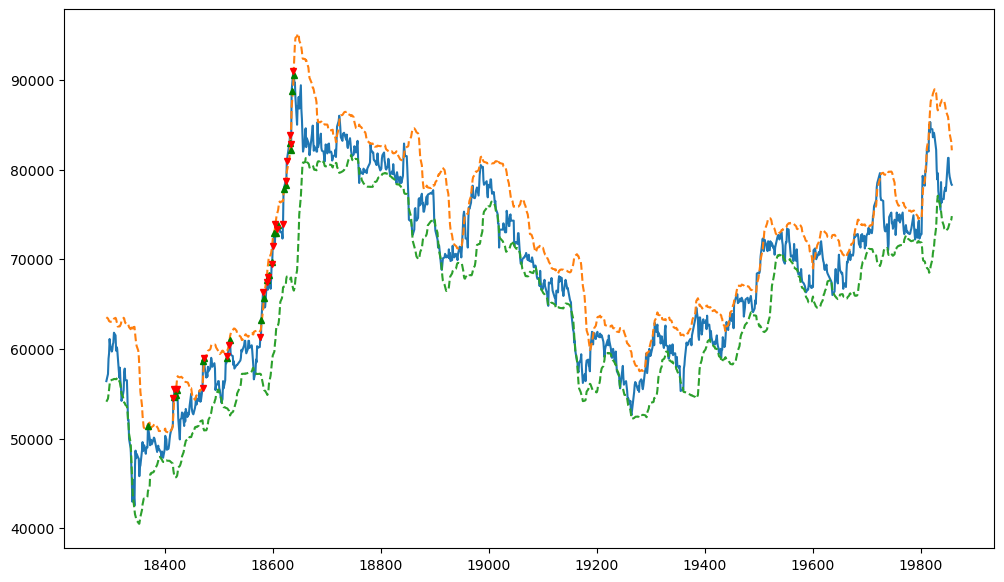

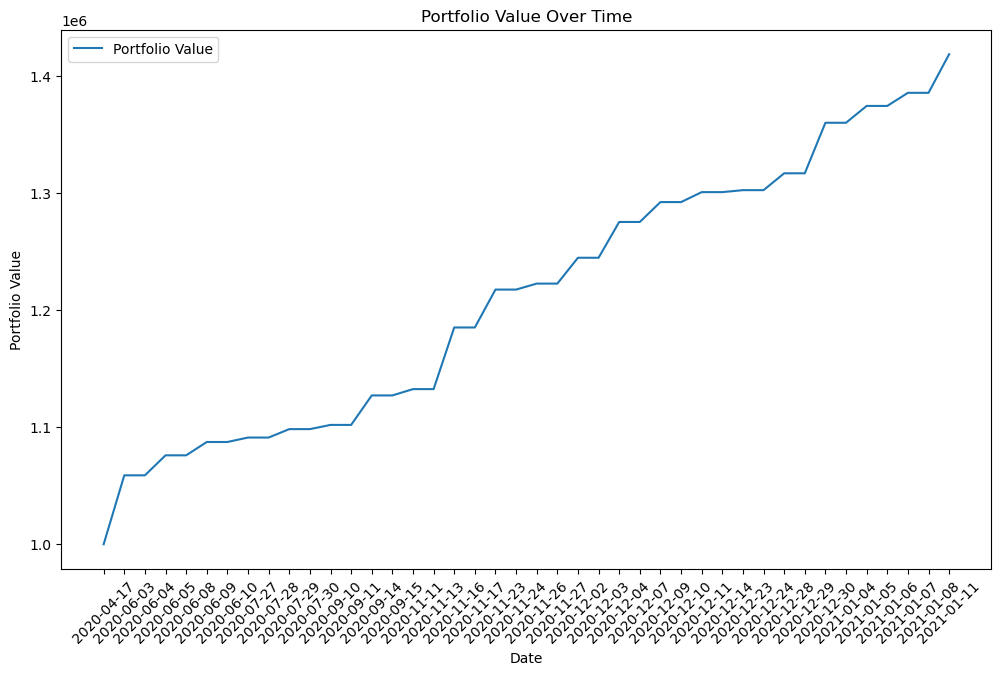

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
import yfinance as yf
import datetime

# 저항선 탐지 함수
def is_Resistance(df, i):
    if df.High[i] == np.max(df.High[i - 20:i + 20 + 1]):
        return True
    else:
        return False

# 볼린저 밴드 및 관련 지표 계산
def calculate_indicators(df):
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['stddev'] = df['Close'].rolling(window=20).std()
    df['upper'] = df['MA20'] + (df['stddev'] * 2)
    df['lower'] = df['MA20'] - (df['stddev'] * 2)
    df['PB'] = (df['Close'] - df['lower']) / (df['upper'] - df['lower'])
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['PMF'] = 0.0
    df['NMF'] = 0.0
    
    for i in range(len(df.Close) - 1):
        if df.TP.values[i] < df.TP.values[i + 1]:
            df.PMF.values[i + 1] = df.TP.values[i + 1] * df.Volume.values[i + 1]
            df.NMF.values[i + 1] = 0.0
        else:
            df.NMF.values[i + 1] = df.TP.values[i + 1] * df.Volume.values[i + 1]
            df.PMF.values[i + 1] = 0.0
            
    df['MFR'] = df.PMF.rolling(window=10).sum() / df.NMF.rolling(window=10).sum()
    df['MFI10'] = 100 - 100 / (1 + df['MFR'])

    # NaN 값 처리
    df = df.dropna()
    
    return df

# 저항선 찾기
def find_resistance_levels(df):
    s = np.mean(df.High - df.Low)
    levels_resistance = []
    for i in range(20, df.shape[0] - 20):
        if is_Resistance(df, i):
            l = df.High[i]
            if np.sum([abs(l - x[1]) < s * 2 for x in levels_resistance]) == 0:
                levels_resistance.append((i, l))
    return levels_resistance

# 매수 및 매도 시그널 생성
def generate_signals(df, levels_resistance):
    buy_signals = []
    sell_signals = []
    in_position = False
    last_buy_price = 0
    
    for i in range(len(df)):
        if df.PB[i] > 0.8 and not in_position:
            buy_signals.append((i, df.Close[i]))
            in_position = True
            last_buy_price = df.Close[i]
        
        if in_position:
            for level in levels_resistance:
                if df.High[i] >= level[1] and df.Close[i] > last_buy_price:
                    sell_signals.append((i, df.Close[i]))
                    in_position = False
                    break
    
    return buy_signals, sell_signals

# 백테스팅 함수
def backtest(df, buy_signals, sell_signals, initial_balance=1000000):
    balance = initial_balance
    portfolio = 0
    trade_log = []
    portfolio_value = []
    
    for buy, sell in zip(buy_signals, sell_signals):
        buy_date, buy_price = buy
        sell_date, sell_price = sell
        
        shares_bought = balance // buy_price
        balance -= shares_bought * buy_price
        portfolio += shares_bought
        
        trade_log.append({
            'Date': pd.to_datetime(mpl_dates.num2date(df['Date'][buy_date])).strftime('%Y-%m-%d'),
            'Type': 'Buy',
            'Price': buy_price,
            'Shares': shares_bought,
            'Balance': balance,
            'Portfolio Value': balance + portfolio * buy_price
        })
        portfolio_value.append((pd.to_datetime(mpl_dates.num2date(df['Date'][buy_date])).strftime('%Y-%m-%d'), balance + portfolio * buy_price))
        
        balance += shares_bought * sell_price
        portfolio -= shares_bought
        
        trade_log.append({
            'Date': pd.to_datetime(mpl_dates.num2date(df['Date'][sell_date])).strftime('%Y-%m-%d'),
            'Type': 'Sell',
            'Price': sell_price,
            'Shares': -shares_bought,
            'Balance': balance,
            'Portfolio Value': balance + portfolio * sell_price
        })
        portfolio_value.append((pd.to_datetime(mpl_dates.num2date(df['Date'][sell_date])).strftime('%Y-%m-%d'), balance + portfolio * sell_price))
    
    # 최종 잔액 및 포트폴리오 가치 계산
    final_balance = balance + portfolio * df['Close'].iloc[-1]
    return trade_log, final_balance, portfolio_value

# 포트폴리오 그래프 출력 함수
def plot_portfolio(portfolio_value):
    dates, values = zip(*portfolio_value)
    plt.figure(figsize=(12, 7))
    plt.plot(dates, values, label='Portfolio Value')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

if __name__ == '__main__':
    plt.rcParams['figure.figsize'] = [12, 7]
    plt.rc('font', size=10)

    end_date = datetime.datetime.today()
    start_date = '2020-01-01'

    stk_code = input('티커를 입력하세요: ')
    df = yf.download(stk_code, start=start_date, end=end_date)
    
    # NaN 값 처리
    df = df.dropna()
    df['Date'] = pd.to_datetime(df.index)
    df['Date'] = df['Date'].apply(mpl_dates.date2num)
    df = df.loc[:, ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    
    # 지표 계산
    df = calculate_indicators(df)
    
    # 저항선 찾기
    levels_resistance = find_resistance_levels(df)
    
    # 매수 및 매도 시그널 생성
    buy_signals, sell_signals = generate_signals(df, levels_resistance)
    
    # 백테스팅 수행
    trade_log, final_balance, portfolio_value = backtest(df, buy_signals, sell_signals)
    
    # 포트폴리오 결과 출력
    print(f"Initial Balance: {1000000}")
    print(f"Final Balance: {final_balance}")
    print("수익률은",((final_balance/1000000)-1)*100,"%입니다.")
    print("Trade Log:")
    for trade in trade_log:
        print(trade)
    
    # 시그널 시각화
    plt.figure()
    plt.plot(df['Date'], df['Close'], label='Close Price')
    plt.plot(df['Date'], df['upper'], label='Upper Band', linestyle='--')
    plt.plot(df['Date'], df['lower'], label='Lower Band', linestyle='--')
    
    for signal in buy_signals:
        plt.plot(df['Date'][signal[0]], signal[1], marker='^', color='g', markersize=5, label='Buy Signal')
    
    for signal in sell_signals:
        plt.plot(df['Date'][signal[0]], signal[1], marker='v', color='r', markersize=5, label='Sell Signal')

    plt.show()
    
    # 포트폴리오 그래프 출력
    plot_portfolio(portfolio_value)


티커를 입력하세요:  005930.ks


[*********************100%%**********************]  1 of 1 completed


Initial Balance: 1000000
Final Balance: 1257800.0
수익률은 25.78 %입니다.
Trade Log:
{'Date': '2020-01-31', 'Type': 'Buy', 'Price': 56400.0, 'Shares': 17.0, 'Balance': 41200.0, 'Portfolio Value': 1000000.0}
{'Date': '2020-02-03', 'Type': 'Sell', 'Price': 57200.0, 'Shares': -17.0, 'Balance': 1013600.0, 'Portfolio Value': 1013600.0}
{'Date': '2020-02-04', 'Type': 'Buy', 'Price': 58900.0, 'Shares': 17.0, 'Balance': 12300.0, 'Portfolio Value': 1013600.0}
{'Date': '2020-02-05', 'Type': 'Sell', 'Price': 59500.0, 'Shares': -17.0, 'Balance': 1023800.0, 'Portfolio Value': 1023800.0}
{'Date': '2020-02-06', 'Type': 'Buy', 'Price': 61100.0, 'Shares': 16.0, 'Balance': 46200.0, 'Portfolio Value': 1023800.0}
{'Date': '2020-02-14', 'Type': 'Sell', 'Price': 61800.0, 'Shares': -16.0, 'Balance': 1035000.0, 'Portfolio Value': 1035000.0}
{'Date': '2020-02-17', 'Type': 'Buy', 'Price': 61500.0, 'Shares': 16.0, 'Balance': 51000.0, 'Portfolio Value': 1035000.0}
{'Date': '2020-11-13', 'Type': 'Sell', 'Price': 63200.0,

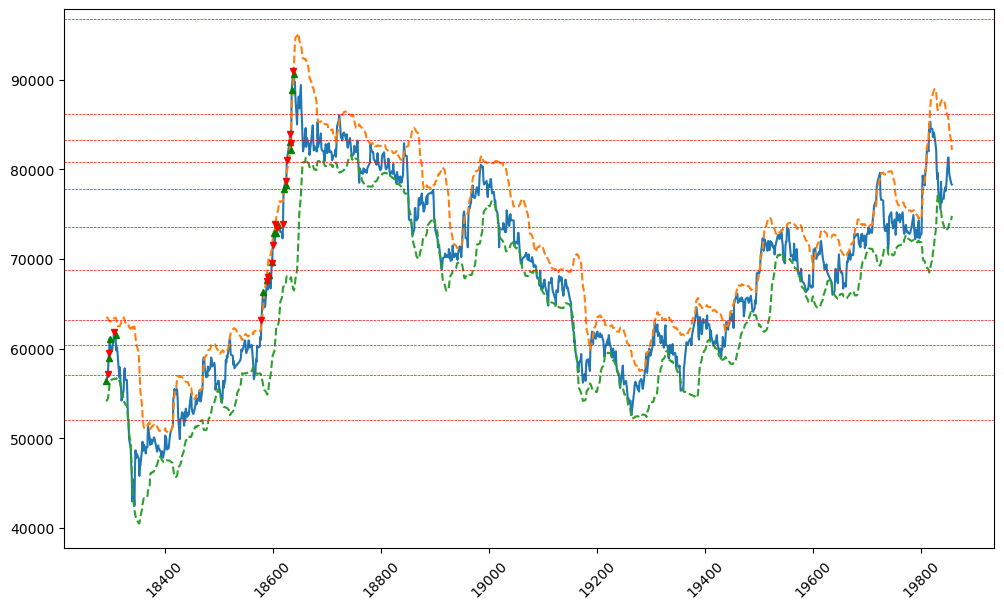

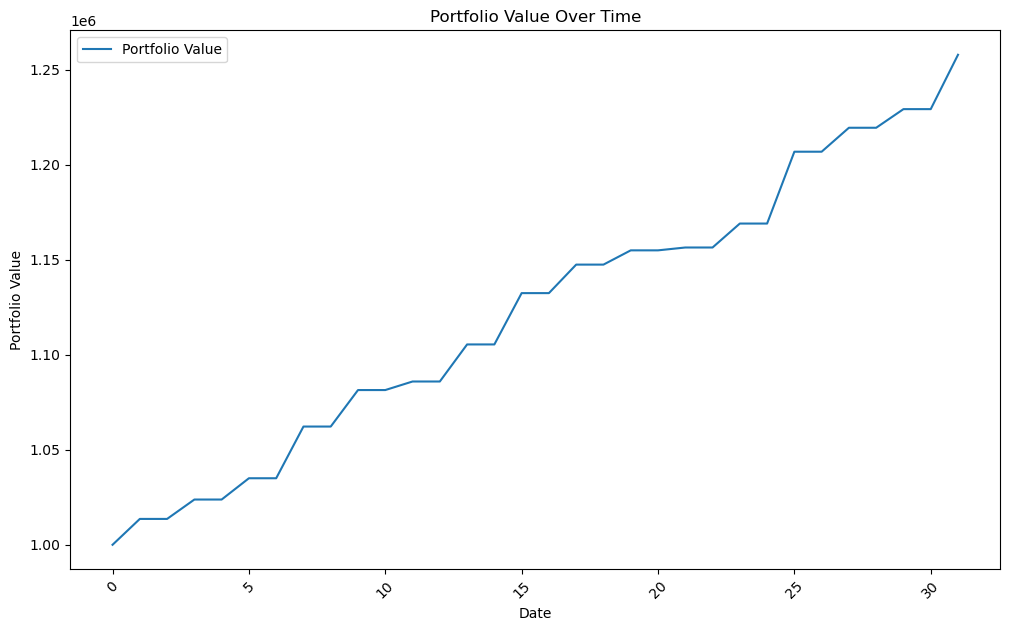

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
import yfinance as yf
import datetime

# 저항선 탐지 함수
def is_Resistance(df, i):
    if df.High[i] == np.max(df.High[i - 20:i + 20 + 1]):
        return True
    else:
        return False

# 볼린저 밴드 및 관련 지표 계산
def calculate_indicators(df):
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['stddev'] = df['Close'].rolling(window=20).std()
    df['upper'] = df['MA20'] + (df['stddev'] * 2)
    df['lower'] = df['MA20'] - (df['stddev'] * 2)
    df['PB'] = (df['Close'] - df['lower']) / (df['upper'] - df['lower'])
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['PMF'] = 0.0
    df['NMF'] = 0.0
    
    for i in range(len(df.Close) - 1):
        if df.TP.values[i] < df.TP.values[i + 1]:
            df.PMF.values[i + 1] = df.TP.values[i + 1] * df.Volume.values[i + 1]
            df.NMF.values[i + 1] = 0.0
        else:
            df.NMF.values[i + 1] = df.TP.values[i + 1] * df.Volume.values[i + 1]
            df.PMF.values[i + 1] = 0.0
            
    df['MFR'] = df.PMF.rolling(window=10).sum() / df.NMF.rolling(window=10).sum()
    df['MFI10'] = 100 - 100 / (1 + df['MFR'])

    # NaN 값 처리
    df = df.dropna()
    
    return df

# 저항선 찾기
def find_resistance_levels(df):
    s = np.mean(df.High - df.Low)
    levels_resistance = []
    for i in range(20, df.shape[0] - 20):
        if is_Resistance(df, i):
            l = df.High[i]
            if np.sum([abs(l - x[1]) < s * 2 for x in levels_resistance]) == 0:
                levels_resistance.append((i, l))
    return levels_resistance

# 매수 및 매도 시그널 생성
def generate_signals(df, levels_resistance):
    buy_signals = []
    sell_signals = []
    in_position = False
    last_buy_price = 0
    
    for i in range(len(df)):
        # 매수 신호 수정: PB > 0.8 인 조건을 제거하여 최고점 찍고 내려오는 경우에도 매수 신호가 발생하도록 함
        if not in_position:
            buy_signals.append((i, df.Close[i]))
            in_position = True
            last_buy_price = df.Close[i]
        
        if in_position:
            for level in levels_resistance:
                if df.High[i] >= level[1] and df.Close[i] > last_buy_price:
                    sell_signals.append((i, df.Close[i]))
                    in_position = False
                    break
    
    return buy_signals, sell_signals

# 백테스팅 함수
def backtest(df, buy_signals, sell_signals, initial_balance=1000000):
    balance = initial_balance
    portfolio = 0
    trade_log = []
    portfolio_value = []
    
    for buy, sell in zip(buy_signals, sell_signals):
        buy_date, buy_price = buy
        sell_date, sell_price = sell
        
        shares_bought = balance // buy_price
        balance -= shares_bought * buy_price
        portfolio += shares_bought
        
        trade_log.append({
            'Date': pd.to_datetime(mpl_dates.num2date(df['Date'][buy_date])).strftime('%Y-%m-%d'),
            'Type': 'Buy',
            'Price': buy_price,
            'Shares': shares_bought,
            'Balance': balance,
            'Portfolio Value': balance + portfolio * buy_price
        })
        portfolio_value.append((pd.to_datetime(mpl_dates.num2date(df['Date'][buy_date])).strftime('%Y-%m-%d'), balance + portfolio * buy_price))
        
        balance += shares_bought * sell_price
        portfolio -= shares_bought
        
        trade_log.append({
            'Date': pd.to_datetime(mpl_dates.num2date(df['Date'][sell_date])).strftime('%Y-%m-%d'),
            'Type': 'Sell',
            'Price': sell_price,
            'Shares': -shares_bought,
            'Balance': balance,
            'Portfolio Value': balance + portfolio * sell_price
        })
        portfolio_value.append((pd.to_datetime(mpl_dates.num2date(df['Date'][sell_date])).strftime('%Y-%m-%d'), balance + portfolio * sell_price))
    
    # 최종 잔액 및 포트폴리오 가치 계산
    final_balance = balance + portfolio * df['Close'].iloc[-1]
    return trade_log, final_balance, portfolio_value

# 포트폴리오 그래프 출력 함수
def plot_portfolio(portfolio_value):
    dates, values = zip(*portfolio_value)
    plt.figure(figsize=(12, 7))
    plt.plot(values, label='Portfolio Value')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

if __name__ == '__main__':
    plt.rcParams['figure.figsize'] = [12, 7]
    plt.rc('font', size=10)

    end_date = datetime.datetime.today()
    start_date = '2020-01-01'

    stk_code = input('티커를 입력하세요: ')
    df = yf.download(stk_code, start=start_date, end=end_date)
    
    # NaN 값 처리
    df = df.dropna()
    df['Date'] = pd.to_datetime(df.index)
    df['Date'] = df['Date'].apply(mpl_dates.date2num)
    df = df.loc[:, ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    
    # 지표 계산
    df = calculate_indicators(df)
    
    # 저항선 찾기
    levels_resistance = find_resistance_levels(df)
    
    # 매수 및 매도 시그널 생성
    buy_signals, sell_signals = generate_signals(df, levels_resistance)
    
    # 백테스팅 수행
    trade_log, final_balance, portfolio_value = backtest(df, buy_signals, sell_signals)
    
    # 포트폴리오 결과 출력
    print(f"Initial Balance: {1000000}")
    print(f"Final Balance: {final_balance}")
    print("수익률은", ((final_balance/1000000)-1)*100,"%입니다.")
    print("Trade Log:")
    for trade in trade_log:
        print(trade)
    
    # 시그널 시각화
    plt.figure()
    plt.plot(df['Date'], df['Close'], label='Close Price')
    plt.plot(df['Date'], df['upper'], label='Upper Band', linestyle='--')
    plt.plot(df['Date'], df['lower'], label='Lower Band', linestyle='--')
    
    for signal in buy_signals:
        plt.plot(df['Date'][signal[0]], signal[1], marker='^', color='g', markersize=5, label='Buy Signal')
    
    for signal in sell_signals:
        plt.plot(df['Date'][signal[0]], signal[1], marker='v', color='r', markersize=5, label='Sell Signal')
    
    # 20일 저항선 표시
    for level in levels_resistance:
        plt.axhline(y=level[1], color='r', linestyle='--', linewidth=0.5)

    plt.xticks(rotation=45)
    plt.show()
    
    # 포트폴리오 그래프 출력
    plot_portfolio(portfolio_value)


티커를 입력하세요:  005930.ks


[*********************100%%**********************]  1 of 1 completed


Initial Balance: 1000000
Final Balance: 1072300.0
수익률은 7.230000000000003 %입니다.
Trade Log:
{'Date': '2020-02-27', 'Type': 'Buy', 'Price': 55900.0, 'Shares': 17.0, 'Balance': 49700.0, 'Portfolio Value': 1000000.0}
{'Date': '2020-03-04', 'Type': 'Sell', 'Price': 57400.0, 'Shares': -17.0, 'Balance': 1025500.0, 'Portfolio Value': 1025500.0}
{'Date': '2021-09-29', 'Type': 'Buy', 'Price': 74100.0, 'Shares': 13.0, 'Balance': 62200.0, 'Portfolio Value': 1025500.0}
{'Date': '2021-11-22', 'Type': 'Sell', 'Price': 74900.0, 'Shares': -13.0, 'Balance': 1035900.0, 'Portfolio Value': 1035900.0}
{'Date': '2022-01-21', 'Type': 'Buy', 'Price': 75600.0, 'Shares': 13.0, 'Balance': 53100.0, 'Portfolio Value': 1035900.0}
{'Date': '2023-12-22', 'Type': 'Sell', 'Price': 75900.0, 'Shares': -13.0, 'Balance': 1039800.0, 'Portfolio Value': 1039800.0}
{'Date': '2024-04-22', 'Type': 'Buy', 'Price': 76100.0, 'Shares': 13.0, 'Balance': 50500.0, 'Portfolio Value': 1039800.0}
{'Date': '2024-04-24', 'Type': 'Sell', 'Pric

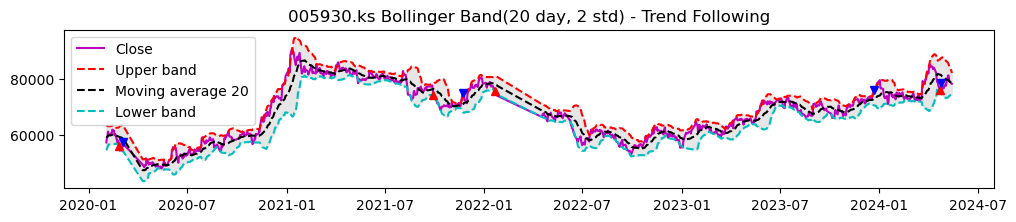

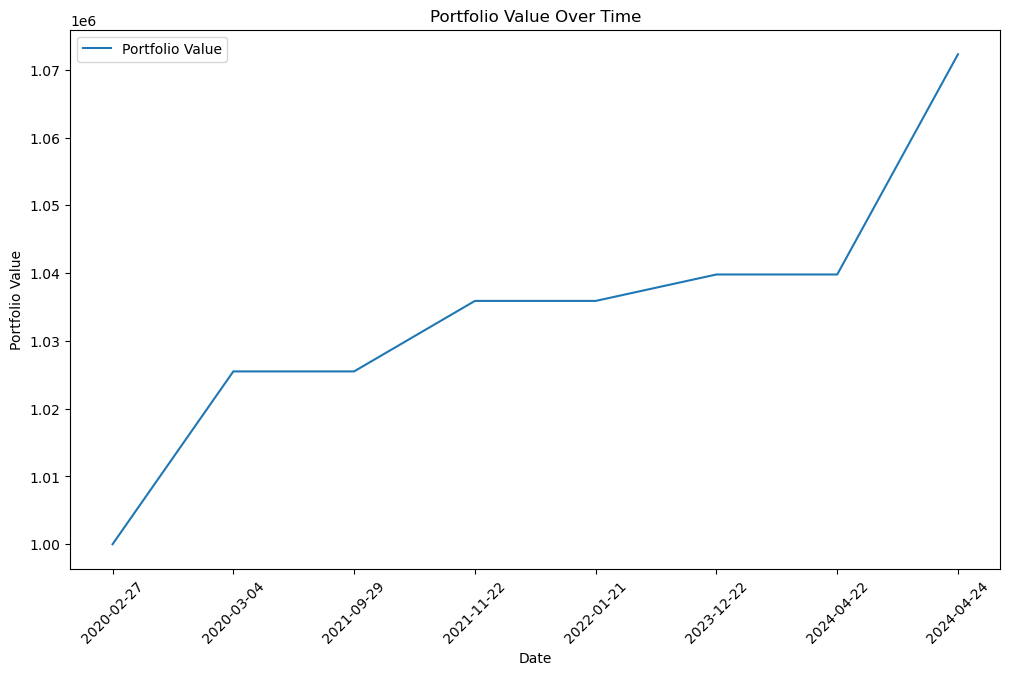

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
import yfinance as yf
import datetime
import warnings
warnings.filterwarnings(action='ignore')

# 저항선 탐지 함수
def is_Resistance(df, i):
    if df.High[i] == np.max(df.High[i - 20:i + 20 + 1]):
        return True
    else:
        return False

# 지표 계산 함수
def calculate_indicators(df):
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['stddev'] = df['Close'].rolling(window=20).std()
    df['upper'] = df['MA20'] + (df['stddev'] * 2)
    df['lower'] = df['MA20'] - (df['stddev'] * 2)
    df['PB'] = (df['Close'] - df['lower']) / (df['upper'] - df['lower'])

    # Intraday Intensity 계산
    df['II'] = (2 * df['Close'] - df['High'] - df['Low']) / (df['High'] - df['Low']) * df['Volume']
    df['IIP21'] = df['II'].rolling(window=21).sum() / df['Volume'].rolling(window=21).sum() * 100

    # NaN 값 처리
    df = df.dropna()
    
    return df

# 저항선 찾기
def find_resistance_levels(df):
    s = np.mean(df.High - df.Low)
    levels_resistance = []
    for i in range(20, df.shape[0] - 20):
        if is_Resistance(df, i):
            l = df.High[i]
            if np.sum([abs(l - x[1]) < s * 2 for x in levels_resistance]) == 0:
                levels_resistance.append((i, l))
    return levels_resistance

# 매수 및 매도 시그널 생성
def generate_signals(df, levels_resistance):
    buy_signals = []
    sell_signals = []
    in_position = False
    last_buy_price = 0
    
    for i in range(len(df)):
        # PB < 0.05 및 IIP21 > 0 조건을 이용한 매수 신호 생성
        if df.PB[i] < 0.05 and df.IIP21[i] > 0 and not in_position:
            buy_signals.append((i, df.Close[i]))
            in_position = True
            last_buy_price = df.Close[i]
        
        # 매수 가격보다 높은 20일 저항선에서 매도 신호 생성
        if in_position:
            for level in levels_resistance:
                if df.High[i] >= level[1] and df.Close[i] > last_buy_price:
                    sell_signals.append((i, df.Close[i]))
                    in_position = False
                    break
    
    return buy_signals, sell_signals

# 백테스팅 함수
def backtest(df, buy_signals, sell_signals, initial_balance=1000000):
    balance = initial_balance
    portfolio = 0
    trade_log = []
    portfolio_value = []
    
    for buy, sell in zip(buy_signals, sell_signals):
        buy_date, buy_price = buy
        sell_date, sell_price = sell
        
        shares_bought = balance // buy_price
        balance -= shares_bought * buy_price
        portfolio += shares_bought
        
        trade_log.append({
            'Date': pd.to_datetime(mpl_dates.num2date(df['Date'][buy_date])).strftime('%Y-%m-%d'),
            'Type': 'Buy',
            'Price': buy_price,
            'Shares': shares_bought,
            'Balance': balance,
            'Portfolio Value': balance + portfolio * buy_price
        })
        portfolio_value.append((pd.to_datetime(mpl_dates.num2date(df['Date'][buy_date])).strftime('%Y-%m-%d'), balance + portfolio * buy_price))
        
        balance += shares_bought * sell_price
        portfolio -= shares_bought
        
        trade_log.append({
            'Date': pd.to_datetime(mpl_dates.num2date(df['Date'][sell_date])).strftime('%Y-%m-%d'),
            'Type': 'Sell',
            'Price': sell_price,
            'Shares': -shares_bought,
            'Balance': balance,
            'Portfolio Value': balance + portfolio * sell_price
        })
        portfolio_value.append((pd.to_datetime(mpl_dates.num2date(df['Date'][sell_date])).strftime('%Y-%m-%d'), balance + portfolio * sell_price))
    
    # 최종 잔액 및 포트폴리오 가치 계산
    final_balance = balance + portfolio * df['Close'].iloc[-1]
    return trade_log, final_balance, portfolio_value

# 포트폴리오 그래프 출력 함수
def plot_portfolio(portfolio_value):
    dates, values = zip(*portfolio_value)
    plt.figure(figsize=(12, 7))
    plt.plot(dates, values, label='Portfolio Value')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.title('Portfolio Value Over Time')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

if __name__ == '__main__':
    plt.rcParams['figure.figsize'] = [12, 7]
    plt.rc('font', size=10)

    Ticker = input('티커를 입력하세요: ')
    df = yf.download(Ticker, start='2020-01-02')
    
    # NaN 값 처리
    df = df.dropna()
    df['Date'] = pd.to_datetime(df.index)
    df['Date'] = df['Date'].apply(mpl_dates.date2num)
    df = df.loc[:, ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    
    # 지표 계산
    df = calculate_indicators(df)
    
    # 저항선 찾기
    levels_resistance = find_resistance_levels(df)
    
    # 매수 및 매도 시그널 생성
    buy_signals, sell_signals = generate_signals(df, levels_resistance)
    
    # 백테스팅 수행
    trade_log, final_balance, portfolio_value = backtest(df, buy_signals, sell_signals)
    
    # 포트폴리오 결과 출력
    print(f"Initial Balance: {1000000}")
    print(f"Final Balance: {final_balance}")
    print("수익률은", ((final_balance/1000000)-1)*100,"%입니다.")
    print("Trade Log:")
    for trade in trade_log:
        print(trade)
    
    # 시그널 시각화
    plt.figure()
    plt.subplot(3, 1, 1)
    plt.title(f'{Ticker} Bollinger Band(20 day, 2 std) - Trend Following')
    plt.plot(df.index, df['Close'], 'm', label='Close')
    plt.plot(df.index, df['upper'], 'r--', label='Upper band')
    plt.plot(df.index, df['MA20'], 'k--', label='Moving average 20')
    plt.plot(df.index, df['lower'], 'c--', label='Lower band')
    plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')
    for signal in buy_signals:
        plt.plot(df.index[signal[0]], df.Close[signal[0]], 'r^')
    for signal in sell_signals:
        plt.plot(df.index[signal[0]], df.Close[signal[0]], 'bv')
    plt.legend(loc='best')

    '''plt.subplot(3, 1, 2)
    plt.plot(df.index, df['PB'], 'b', label='%B')
    plt.grid(True)
    plt.legend(loc='best')

    plt.subplot(3, 1, 3)
    plt.bar(df.index, df['IIP21'], color='g', label='II% 21 day')
    for signal in buy_signals:
        plt.plot(df.index[signal[0]], 0, 'r^')
    for signal in sell_signals:
        plt.plot(df.index[signal[0]], 0, 'bv')
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()'''
    
    # 포트폴리오 그래프 출력
    plot_portfolio(portfolio_value)
